# Ovarian dataset Logistic Regression using MCMC

In [14]:

%matplotlib inline
from itertools import chain

from cmdstanpy import CmdStanModel
import numpy as np
import pandas as pd
from pathlib import Path
import nest_asyncio
nest_asyncio.apply()
from random import choices



In [15]:

import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_probability.python.bijectors as tfb

from bayesianquilts.models.logistic_regression_reparam import LogisticRegression2
from bayesianquilts.metrics.classification import classification_metrics
# from bayesianquilts.sampler import psis, nppsis

In [16]:

X_ = pd.read_csv(Path.home() / "workspace" / "bayesianquilts"/ "bayesianquilts"/ "data" / "overianx.csv", header=None)
y_ = pd.read_table(Path.home() / "workspace" / "bayesianquilts"/ "bayesianquilts"/ "data" / "overiany.csv", header=None)


X_scaled = (X_ - X_.mean())/X_.std()
X_scaled = X_scaled.fillna(0).to_numpy()
y_ = y_.to_numpy()
N = X_scaled.shape[0]
d = X_scaled.shape[1]

print((N, d))

(54, 1536)


In [17]:
logistic_horseshoe_code = """
data {
  int <lower=0> N;                // number  of  observations
  int <lower=0> d;                // number  of  predictors
  array[N] int<lower=0,upper=1> y;      // outputs
  matrix[N,d] x;                  // inputs
  real <lower=0>  scale_icept;    // prior  std for  the  intercept
  real <lower=0>  scale_global;   // scale  for  the half -t prior  for  tau
  real <lower=1>  nu_global;      // degrees  of  freedom  for the half -t prior for tau
  real <lower=1> nu_local;        // degrees  of  freedom  for  the half -t priors for  lambdas
  real <lower=0>  slab_scale;     // slab  scale  for  the  regularized  horseshoe
  real <lower=0> slab_df;         // slab  degrees  of  freedom  for the  regularized horseshoe

  //int<lower=0> N_tilde;
  //matrix[N_tilde, d] x_tilde;
  //array[N_tilde] int<lower=0,upper=1> y_obs;
}
parameters {
  real  beta0;
  vector[d] z;
  real <lower=0> tau;             // global  shrinkage  parameter
  vector <lower =0>[d] lambda;    // local  shrinkage  parameter
  real <lower=0> caux;
}
transformed  parameters {
  vector <lower =0>[d] lambda_tilde;    // ’truncated ’ local  shrinkage  parameter
  real <lower=0> c;                     // slab  scale
  vector[d] beta;                       // regression  coefficients
  vector[N] f;                          // latent  function  values
  c = slab_scale * sqrt(caux);
  lambda_tilde = sqrt( c^2 * square(lambda) ./ (c^2 + tau^2* square(lambda )) );
  beta = z .*  lambda_tilde*tau;
  f = beta0 + x*beta;
}
model {
  z ~ normal(0.0, 1.0); // half -t priors  for  lambdas  and tau , and  inverse -gamma  for c^2
  lambda ~ student_t(nu_local , 0.0, 1.0);
  tau ~ student_t(nu_global , 0.0, scale_global);
  caux ~ inv_gamma (0.5* slab_df , 0.5* slab_df );
  beta0 ~ normal(0.0,  scale_icept );
  y ~ bernoulli_logit(f);
}
generated quantities {
  vector[N] log_lik;
  // vector[N_tilde] loo_log_lik;

  for (nn in 1:N)
    log_lik[nn] = bernoulli_logit_lpmf(y[nn] | x[nn] * beta + beta0);

  //for (nn in 1:N_tilde)
  //  loo_log_lik[nn] = bernoulli_logit_lpmf(y_obs[nn] | x_tilde[nn] * beta + beta0);
}
"""

with open("ovarian_model.stan", 'w') as f:
  f.writelines(logistic_horseshoe_code)


In [18]:
sm = CmdStanModel(stan_file="ovarian_model.stan")

01:10:22 - cmdstanpy - INFO - compiling stan file /Users/changjc/workspace/bayesianquilts/ovarian_model.stan to exe file /Users/changjc/workspace/bayesianquilts/ovarian_model
01:10:32 - cmdstanpy - INFO - compiled model executable: /Users/changjc/workspace/bayesianquilts/ovarian_model


In [19]:
guessnumrelevcov = 20 # 20.
slab_scale = 2.5/100
scale_icept = 5.0
nu_global = 1
nu_local = 1
slab_df = 1
scale_global = guessnumrelevcov / ((d - guessnumrelevcov) * np.sqrt(N))/10000

control = {"adapt_delta": 0.9995, "max_treedepth": 15}

ovarian_data = {
    "N": N,
    "d": d,
    "slab_df": slab_df,
    "slab_scale": slab_scale,
    "scale_icept": scale_icept,
    "nu_global": 1,
    "nu_local": 1,
    "scale_global": scale_global,
    "y": y_.astype(int)[:, 0].tolist(),
    "x": X_scaled.tolist(),
}

import json
with open("ovarian_data.json", 'w') as f:
    json.dump(ovarian_data, f)

In [20]:
fit = sm.sample(
    data="ovarian_data.json",
    iter_warmup=20000,
    iter_sampling=2000,
    thin=2,
    adapt_delta=0.9995,
    max_treedepth=15,
)

01:10:32 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |          | 00:03 Iteration:     1 / 22000 [  0%]  (Warmup)




chain 1 |▏         | 00:15 Iteration:   100 / 22000 [  0%]  (Warmup)



chain 1 |▏         | 00:27 Iteration:   200 / 22000 [  0%]  (Warmup)

chain 1 |▏         | 00:32 Iteration:   300 / 22000 [  1%]  (Warmup)
chain 1 |▎         | 00:44 Iteration:   400 / 22000 [  1%]  (Warmup)

chain 1 |▎         | 00:47 Iteration:   500 / 22000 [  2%]  (Warmup)



chain 1 |▎         | 00:56 Iteration:   600 / 22000 [  2%]  (Warmup)


chain 1 |▍         | 01:02 Iteration:   700 / 22000 [  3%]  (Warmup)


chain 1 |▍         | 01:12 Iteration:   800 / 22000 [  3%]  (Warmup)
chain 1 |▌         | 01:22 Iteration:  1000 / 22000 [  4%]  (Warmup)
chain 1 |▌         | 01:28 Iteration:  1100 / 22000 [  5%]  (Warmup)


chain 1 |▋         | 01:34 Iteration:  1200 / 22000 [  5%]  (Warmup)


chain 1 |▋         | 01:46 Iteration:  1400 / 22000 [  6%]  

In [ ]:
print(fit)

CmdStanMCMC: model=ovarian_model chains=4['method=sample', 'num_samples=2000', 'num_warmup=20000', 'thin=2', 'algorithm=hmc', 'engine=nuts', 'max_depth=15', 'adapt', 'engaged=1', 'delta=0.9995']
 csv_files:
	/var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tmpn_15wk27/ovarian_modelg6w_h2cs/ovarian_model-20240403143919_1.csv
	/var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tmpn_15wk27/ovarian_modelg6w_h2cs/ovarian_model-20240403143919_2.csv
	/var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tmpn_15wk27/ovarian_modelg6w_h2cs/ovarian_model-20240403143919_3.csv
	/var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tmpn_15wk27/ovarian_modelg6w_h2cs/ovarian_model-20240403143919_4.csv
 output_files:
	/var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tmpn_15wk27/ovarian_modelg6w_h2cs/ovarian_model-20240403143919_0-stdout.txt
	/var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tmpn_15wk27/ovarian_modelg6w_h2cs/ovarian_model-20240403143919_1-stdout.txt
	/var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/

In [ ]:
print(fit.diagnose())

Processing csv files: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tmpn_15wk27/ovarian_modelg6w_h2cs/ovarian_model-20240403143919_1.csv, /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tmpn_15wk27/ovarian_modelg6w_h2cs/ovarian_model-20240403143919_2.csv, /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tmpn_15wk27/ovarian_modelg6w_h2cs/ovarian_model-20240403143919_3.csv, /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tmpn_15wk27/ovarian_modelg6w_h2cs/ovarian_model-20240403143919_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

The following parameters had split R-hat greater than 1.05:
  z[1491], beta[1483], beta[1491], log_lik[6], log_lik[24], log_lik[36]
Such high values indicate incomplete mixing and biased estimation.
You should consider 

In [ ]:
fit.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-2944.360000,0.891933,44.848600,-3017.660000,-2943.840000,-2.871370e+03,2528.330,3.200170,0.999570
beta0,1.897480,0.041331,1.536620,0.211224,1.553170,4.918340e+00,1382.240,1.749540,1.003990
z[1],-0.002240,0.018340,0.994213,-1.664430,0.023410,1.647160e+00,2938.710,3.719610,1.000440
z[2],0.029255,0.017222,0.988722,-1.562150,0.013512,1.668730e+00,3296.000,4.171840,1.000590
z[3],0.027492,0.018476,1.005450,-1.611880,0.025639,1.685690e+00,2961.450,3.748390,0.999808
...,...,...,...,...,...,...,...,...,...
log_lik[50],-0.011049,0.000948,0.043544,-0.048252,-0.001078,-6.316170e-10,2108.790,2.669150,1.003630
log_lik[51],-0.007900,0.000554,0.032888,-0.036041,-0.000606,-1.213240e-10,3521.240,4.456930,1.000770
log_lik[52],-0.017166,0.002217,0.118038,-0.042076,-0.000550,-2.087550e-09,2833.970,3.587030,1.001800
log_lik[53],-1.244270,0.074662,1.060330,-3.102140,-1.145980,-9.905620e-05,201.686,0.255279,1.032670


In [ ]:
fit.stan_variable('beta0').shape

(4000,)

In [ ]:
fit.stan_variable('beta').shape, X_scaled.shape

((4000, 1536), (54, 1536))

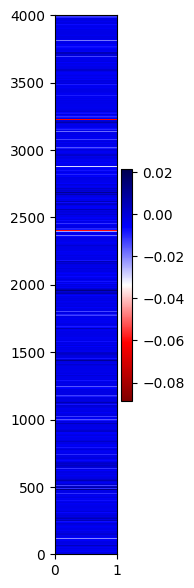

In [ ]:
from matplotlib import pyplot as plt
beta = tf.reduce_mean(fit.stan_variable("beta"), axis=1, keepdims=True)
fig, ax = plt.subplots(1, 1, figsize=(1, 7))
im = ax.pcolormesh(beta, cmap='seismic_r')
plt.colorbar(im)

In [ ]:
params = fit.stan_variables()
params.keys()
params['c'] = params['c'][:, tf.newaxis]
params['tau'] = params['tau'][:, tf.newaxis]
params['caux'] = params['caux'][:, tf.newaxis]
params['beta0'] = params['beta0'][:, tf.newaxis]

n_samples = 128
params = {k: v[:n_samples] for k, v in params.items()}

In [ ]:
lr_model = LogisticRegression2(
    dim_regressors=d,
    slab_df=slab_df,
    slab_scale=slab_scale,
    scale_icept=scale_icept,
    nu_global=1,
    nu_local=1,
    scale_global=scale_global,
)

In [ ]:
fit.stan_variable("beta").shape

(4000, 1536)

In [ ]:


tfdata = tf.data.Dataset.from_tensor_slices({'X': X_scaled, 'y':y_})
batch_size = 56
def data_factory_factory(batch_size=batch_size, repeat=False, shuffle=False):
    def data_factory(batch_size=batch_size):
        if shuffle:
            out = tfdata.shuffle(batch_size*10)
        else:
            out = tfdata
        
        if repeat:
            out = out.repeat()
        return out.batch(batch_size)
    return data_factory

batch = next(iter(data_factory_factory()()))

1it [00:00, 36.64it/s]


(0.0, 1.0)

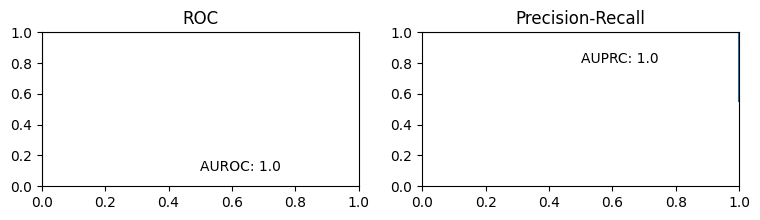

In [ ]:
def prediction_fn(data):
    pred = lr_model.predictive_distribution(data, **params)["logits"]
    return tf.reduce_mean(pred, axis=0)

bench = classification_metrics(
    data_factory=data_factory_factory(),
    prediction_fn=prediction_fn,
    outcome_label='y',
    by_vars=[]
)

fig, ax = plt.subplots(1, 2, figsize=(9, 2))
ax[0].plot(bench['auroc']['fpr'], bench['auroc']['tpr'])
ax[0].text(0.5, 0.1, f"AUROC: {round(bench['auroc']['auroc'], 2)}")
ax[0].set_xlim((0, 1))
ax[0].set_ylim((0, 1))
ax[0].set_title("ROC")

ax[1].plot(bench['auprc']['recall'], bench['auprc']['precision'])
ax[1].text(0.5, 0.8, f"AUPRC: {round(bench['auprc']['auprc'], 2)}")
ax[1].set_title("Precision-Recall")
ax[1].set_xlim((0, 1))
ax[1].set_ylim((0, 1))

In [ ]:
def entropy(probs):
    return -tf.math.xlogy(probs, probs)


def adaptive_is_loo(self, data, params, hbar=1.0, variational=True):
    """_summary_

    Args:
        data (_type_): _description_
        params (_type_): _description_
        hbar (float, optional): _description_. Defaults to 1.0.
        variational (bool, optional):
            Should we trust the variational approximation?
            If False, assumes that one is passing in all the data at once in a single batch.
            Defaults to True.

    Returns:
        _type_: _description_
    """

    # scaled (theta - bar(theta))/Sigma
    c = self.slab_scale * tf.math.sqrt(params["caux"])
    lambda_tilde = tf.math.sqrt(
        c**2
        * params["lambda"] ** 2
        / (c**2 + params["tau"] ** 2 * params["lambda"] ** 2)
    )
    beta = params["z"] * lambda_tilde * params["tau"]
    intercept = params["beta0"]
    X = tf.cast(data["X"], self.dtype)
    y = tf.cast(data["y"], self.dtype)[:, 0]
    mu = beta[..., tf.newaxis, :] * X
    mu = tf.reduce_sum(mu, -1) + params["beta0"]
    sigma = tf.math.sigmoid(mu)
    ell = y * (sigma) + (1 - y) * (1 - sigma)
    log_ell = tf.math.xlogy(y, sigma) + tf.math.xlogy(1 - y, 1 - sigma)
    log_ell_prime = y * (1 - sigma) - (1 - y) * sigma
    log_ell_doubleprime = -sigma * (1 - sigma)
    _, khat0 = nppsis.psislw(-log_ell)

    """
    sigma.shape is samples x datapoints
    """

    # compute # \nabla\log\pi(\btheta|\calD)
    if variational:
        # \nabla\log\pi = -\Sigma^{-1}(theta - \bar{\theta})
        grad_log_pi = tf.concat(
            [
                -(intercept - self.surrogate_distribution.model["intercept__"].mean())
                / self.surrogate_distribution.model["intercept__"].variance(),
                -(beta - self.surrogate_distribution.model["beta__"].mean())
                / self.surrogate_distribution.model["beta__"].variance(),
            ],
            axis=-1,
        )
        intercept_sd = (
            self.surrogate_distribution.model["intercept__"].variance() ** 0.5
        )
        beta_sd = self.surrogate_distribution.model["beta__"].variance() ** 0.5

        log_pi = self.surrogate_distribution.model["beta__"].log_prob(
            params["beta__"]
        ) + self.surrogate_distribution.model["intercept__"].log_prob(
            params["intercept__"]
        )
        log_pi -= tf.reduce_max(log_pi, axis=0)
        # log_pi.shape: [samples]
    else:
        """
        Recall Bayes rule:
        \log pi(\btheta|\calD) = \sum_i\log ell_i(\btheta) + \log\pi(\btheta) + const

        so
        \nabla\log\pi(\btheta|\calD) = \sum_i (ell_i)'x + grad\log\pi(\btheta)

        """
        log_prior = self.prior_distribution.log_prob_parts(params)
        log_prior = log_prior["z"] + log_prior["beta0"]

        log_pi = tf.reduce_sum(log_ell, axis=1, keepdims=True)[:, 0]

        # pi \propto
        grad_log_pi = tf.concat(
            [
                tf.reduce_sum(log_ell_prime[..., tf.newaxis], axis=1, keepdims=True),
                tf.reduce_sum(
                    log_ell_prime[..., tf.newaxis] * X, axis=1, keepdims=True
                ),
            ],
            axis=-1,
        )

        grad_log_prior = -0.5 * tf.concat(
            [(params["beta0"] / self.scale_icept) ** 2, (params["z"]) ** 2],
            axis=-1,
        )
        grad_log_pi += grad_log_prior[:, tf.newaxis, :]

        intercept_sd = tf.math.reduce_std(intercept, 0, keepdims=True)
        beta_sd = tf.math.reduce_std(beta, 0, keepdims=True)

    # log-likelihood descent

    def T_ll():
        Q_beta = -log_ell_prime[..., tf.newaxis] * X
        Q_intercept = -log_ell_prime[..., tf.newaxis]

        standardized = tf.concat(
            [Q_beta / beta_sd, Q_intercept / intercept_sd], axis=-1
        )
        standardized = tf.reduce_max(tf.math.abs(standardized), axis=-1)
        standardized = tf.reduce_max(standardized, axis=0, keepdims=True)[
            ..., tf.newaxis
        ]

        h = hbar / standardized
        logJ = tf.math.log1p(
            tf.math.abs(
                h
                * (1 + tf.math.reduce_sum(X**2, -1, keepdims=True))[tf.newaxis, :, :]
                * (sigma * (1 - sigma))[..., tf.newaxis]
            )[..., 0]
        )
        beta_ll = beta[..., tf.newaxis, :] + h * Q_beta
        intercept_ll = intercept[..., tf.newaxis, :] + h * Q_intercept
        return beta_ll, intercept_ll, logJ

    def T_kl():
        log_pi_ = log_pi - tf.reduce_max(log_pi, axis=0, keepdims=True)
        Q_beta = ((-1) ** y * tf.math.exp(log_pi_[..., tf.newaxis] + mu * (1 - 2 * y)))[
            ..., tf.newaxis
        ] * X
        Q_intercept = (
            ((-1) ** y) * tf.math.exp(log_pi_[..., tf.newaxis] + mu * (1 - 2 * y))
        )[..., tf.newaxis]

        dQ = (-1) ** y[tf.newaxis, :] * tf.math.exp(
            log_pi_[..., tf.newaxis] + mu * (1 - 2 * y[tf.newaxis, :])
        )
        dQ *= (
            grad_log_pi[..., 0]
            + (1 - 2 * y)[tf.newaxis, :]
            + tf.reduce_sum(
                X
                * (
                    grad_log_pi[..., 1:]
                    + (1 - 2 * y)[:, tf.newaxis] * X[tf.newaxis, ...]
                ),
                axis=-1,
            )
        )

        standardized = tf.concat(
            [Q_beta / beta_sd, Q_intercept / intercept_sd], axis=-1
        )
        standardized = tf.reduce_max(tf.math.abs(standardized), axis=-1)
        standardized = tf.reduce_max(standardized, axis=0, keepdims=True)[
            ..., tf.newaxis
        ]

        h = hbar / standardized

        intercept_kl = intercept[..., tf.newaxis] + h * Q_intercept
        beta_kl = beta[..., tf.newaxis, :] + h * Q_beta

        logJ = tf.math.log1p(tf.math.abs(h[..., 0] * dQ))
        return beta_kl, intercept_kl, logJ

    # variance descent -(log ell)'/l

    def T_I():
        Q = tf.zeros_like(log_ell)
        return (
            beta[:, tf.newaxis, :] + Q[..., tf.newaxis],
            intercept[..., tf.newaxis] + Q[..., tf.newaxis],
            tf.zeros_like(Q),
        )

    def T_var():
        log_pi_ = log_pi - tf.reduce_max(log_pi, axis=0, keepdims=True)

        Q_beta = (
            (-1) ** y * tf.math.exp(log_pi_[..., tf.newaxis] + 2 * mu * (1 - 2 * y))
        )[..., tf.newaxis] * X
        Q_intercept = (
            (-1) ** y * tf.math.exp(log_pi_[..., tf.newaxis] + 2 * mu * (1 - 2 * y))
        )[..., tf.newaxis]

        dQ = (
            (-1) ** y[tf.newaxis, :]
            * tf.math.exp(
                log_pi_[..., tf.newaxis] + 2 * mu * (1 - 2 * y[tf.newaxis, :])
            )
            * (
                grad_log_pi[..., 0]
                + (1 - 2 * y)[tf.newaxis, :]
                + tf.reduce_sum(
                    X * (grad_log_pi[..., 1:] + 2 * (1 - 2 * y)[:, tf.newaxis] * X),
                    axis=-1,
                )
            )
        )

        standardized = tf.concat(
            [Q_beta / beta_sd, Q_intercept / intercept_sd], axis=-1
        )
        standardized = tf.reduce_max(tf.math.abs(standardized), axis=-1)
        standardized = tf.reduce_max(standardized, axis=0, keepdims=True)[
            ..., tf.newaxis
        ]

        h = hbar / standardized

        intercept_kl = intercept[..., tf.newaxis, :] + h * Q_intercept
        beta_kl = beta[..., tf.newaxis, :] + h * Q_beta

        logJ = tf.math.log1p(tf.math.abs(h[..., 0] * dQ))
        return beta_kl, intercept_kl, logJ

    def IS(Q):
        beta_new, intercept_new, logJ = Q()
        mu_new = tf.reduce_sum(beta_new * X, axis=-1) + intercept_new[..., 0]
        sigma_new = tf.math.sigmoid(mu_new)
        ell_new = y * (sigma_new) + (1 - y) * (1 - sigma_new)
        log_ell_new = tf.math.xlogy(y, sigma_new) + tf.math.xlogy(1 - y, 1 - sigma_new)
        c = self.slab_scale * tf.math.sqrt(params["caux"])
        lambda_tilde = tf.math.sqrt(
            c**2
            * params["lambda"] ** 2
            / (c**2 + params["tau"] ** 2 * params["lambda"] ** 2)
        )
        transformed = params.copy()
        transformed["z"] = beta_new / (
            lambda_tilde[:, tf.newaxis, :] * params["tau"][..., tf.newaxis]
        )
        transformed["beta0"] = intercept_new

        if variational:
            # We trust the variational approximation, so \hat{pi} = pi
            # N_samples x N_data
            delta_log_pi = (
                self.surrogate_distribution.log_prob(transformed)
                - log_pi[:, tf.newaxis]
            )
            delta_log_pi = delta_log_pi - tf.reduce_max(
                delta_log_pi, axis=0, keepdims=True
            )
            pass
        else:
            # we don't trust the variational approximation
            # Need to compute log_pi directly by summing over the likelihood

            ell_cross = tf.math.sigmoid(
                tf.reduce_sum(beta_new[..., tf.newaxis, :] * X, -1) + intercept_new
            )
            ell_cross = tf.math.xlogy(y, ell_cross) + tf.math.xlogy(
                1 - y, 1 - ell_cross
            )
            ell_cross = tf.math.reduce_sum(ell_cross, axis=-1)

            log_prior_new = self.prior_distribution.log_prob_parts(transformed)
            log_prior_new = log_prior_new["z"] + log_prior_new["beta0"]
            log_pi_new = ell_cross
            delta_log_prior = log_prior_new - log_prior[:, tf.newaxis]
            # Incorporate the prior
            delta_log_pi = log_pi_new - log_pi[:, tf.newaxis] + delta_log_prior
        log_eta_weights = delta_log_pi - log_ell_new + logJ
        log_eta_weights = log_eta_weights - tf.reduce_max(log_eta_weights, axis=0)
        psis_weights, khat = nppsis.psislw(log_eta_weights)
        _, khat_test = nppsis.psislw(-log_ell_new - tf.reduce_max(-log_ell_new, axis=0))

        eta_weights = tf.math.exp(log_eta_weights)
        eta_weights = eta_weights / tf.reduce_sum(eta_weights, axis=0, keepdims=True)

        psis_weights = tf.math.exp(psis_weights)
        psis_weights = psis_weights / tf.math.reduce_sum(
            psis_weights, axis=0, keepdims=True
        )

        weight_entropy = self.entropy(eta_weights)
        psis_entropy = self.entropy(psis_weights)

        p_loo_new = tf.reduce_sum(sigma_new * eta_weights, axis=0)
        p_loo_psis = tf.reduce_sum(sigma_new * psis_weights, axis=0)
        p_loo_sd = tf.math.reduce_std(sigma_new * eta_weights, axis=0)
        ll_loo_new = tf.reduce_sum(eta_weights * ell_new, axis=0)
        ll_loo_psis = tf.reduce_sum(psis_weights * ell_new, axis=0)
        ll_loo_sd = tf.math.reduce_std(eta_weights * ell_new, axis=0)
        return (
            eta_weights,
            psis_weights,
            p_loo_new,
            p_loo_sd,
            ll_loo_new,
            ll_loo_sd,
            weight_entropy,
            khat,
            p_loo_psis,
            ll_loo_psis,
        )

    (
        eta_I,
        eta_I_psis,
        p_loo_I,
        p_loo_I_sd,
        ll_loo_I,
        ll_loo_I_sd,
        S_I,
        k_I,
        p_psis_I,
        ll_psis_I,
    ) = IS(T_I)

    (
        eta_kl,
        eta_kl_psis,
        p_loo_kl,
        p_loo_kl_sd,
        ll_loo_kl,
        ll_loo_kl_sd,
        S_kl,
        k_kl,
        p_psis_kl,
        ll_psis_kl,
    ) = IS(T_kl)

    (
        eta_var,
        eta_var_psis,
        p_loo_var,
        p_loo_var_sd,
        ll_loo_var,
        ll_loo_var_sd,
        S_var,
        k_var,
        p_psis_var,
        ll_psis_var,
    ) = IS(T_var)
    (
        eta_ll,
        eta_ll_psis,
        p_loo_ll,
        p_loo_ll_sd,
        ll_loo_ll,
        ll_loo_ll_sd,
        S_ll,
        k_ll,
        p_psis_ll,
        ll_psis_ll,
    ) = IS(T_ll)
    # kl descent

    return {
        "I": {
            "p_loo": p_loo_I,
            "p_loo_sd": p_loo_I_sd,
            "ll_loo": ll_loo_I,
            "ll_loo_sd": ll_loo_I_sd,
            "S": S_I,
            "khat": k_I,
            "p_psis": p_psis_I,
            "ll_psis": ll_psis_I,
        },
        "KL": {
            "p_loo": p_loo_kl,
            "p_loo_sd": p_loo_kl_sd,
            "ll_loo": ll_loo_kl,
            "ll_loo_sd": ll_loo_kl_sd,
            "S": S_kl,
            "khat": k_kl,
            "p_psis": p_psis_kl,
            "ll_psis": ll_psis_kl,
        },
        "LL": {
            "p_loo": p_loo_kl,
            "p_loo_sd": p_loo_kl_sd,
            "ll_loo": ll_loo_kl,
            "ll_loo_sd": ll_loo_kl_sd,
            "S": S_ll,
            "khat": k_ll,
            "p_psis": p_psis_ll,
            "ll_psis": ll_psis_ll,
        },
        "Var": {
            "p_loo": p_loo_var,
            "p_loo_sd": p_loo_var_sd,
            "ll_loo": ll_loo_var,
            "ll_loo_sd": ll_loo_var_sd,
            "S": S_var,
            "khat": k_var,
            "p_psis": p_psis_var,
            "ll_psis": ll_psis_var,
        },
    }


loo = adaptive_is_loo(lr_model, batch, params, 1e-5, variational=False)

# loo = adaptive_is_loo(lr_model, test_batch, param_test, 0.01, variational=False)


for T in ["I", "LL", "KL", "Var"]:
    print(
        f"{T}: {np.sqrt(np.sum(loo[T]['p_loo_sd']**2))} entropy: {np.sqrt(np.sum(loo[T]['S']))} khat>0.7: {np.sum(loo[T]['khat']>0.7)}"
    )

2024-02-10 04:11:53.635192: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 4586471424 exceeds 10% of free system memory.
2024-02-10 04:11:54.529041: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 4586471424 exceeds 10% of free system memory.
2024-02-10 04:11:55.396526: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 4586471424 exceeds 10% of free system memory.
2024-02-10 04:11:56.235002: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 4586471424 exceeds 10% of free system memory.


I: 0.02715628594455579 entropy: 16.008635804468483 khat>0.7: 12
LL: 0.029092386196232285 entropy: 15.575058021931957 khat>0.7: 38
KL: 0.029092386196232285 entropy: 15.998163500488719 khat>0.7: 22
Var: 0.030714113091867182 entropy: 16.001419969716643 khat>0.7: 22


In [ ]:
khat = pd.DataFrame({"khat": loo["I"]['khat']})
khat = khat.loc[khat.khat> 0.7] 
ndx = np.array(khat.index)
ndx

array([ 3,  9, 15, 17, 21, 28, 29, 33, 44, 48, 49, 51])

In [ ]:
h_vals = [1, 0.5, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]
loo_khat = {}
reduced_ndx = {}
high_khat_ndx = {}
n_sample = [64, 128]

for n_samples in n_sample:
    sample_ndx = choices(range(2000), k=n_samples)
    reduced_ndx[n_samples] = []
    high_khat_ndx[n_samples] = {}
    print(f"Samples: {n_samples}")
    loo_khat[n_samples] = {}
    params = fit.stan_variables()

    params['c'] = params['c'][:, tf.newaxis]
    params['tau'] = params['tau'][:, tf.newaxis]
    params['caux'] = params['caux'][:, tf.newaxis]
    params['beta0'] = params['beta0'][:, tf.newaxis]
    params = {k: v[sample_ndx] for k, v in params.items()}
    
    records = []

    for h in h_vals:
        loo_khat[n_samples][h] = {}
        loo = adaptive_is_loo(lr_model, batch, params, h, variational=False)
        khat = pd.DataFrame({"khat": loo["I"]['khat']})
        khat = khat.loc[khat.khat> 0.7] 
        ndx = np.array(khat.index)
        high_khat_ndx[n_samples][h] = np.where((loo['I']['khat']>0.7))
        print(f"rho={h}\n")
        for T in ["I", "LL", "KL", "Var"]:
            loo_khat[n_samples][h][T] = np.array(loo[T]['khat'])
            
            records += [
                {
                    "h": h,
                    "T": T,
                    "S": n_samples,
                    
                }
            ]
            # print(f"Transform: {T}")
            #print(
            #    f"V: {np.sqrt(np.sum(loo[T]['p_loo_sd']**2))} S: {np.sqrt(np.sum(loo[T]['S']))} khat>0.7: {np.sum(loo[T]['khat']>0.7)}"
            #)
            #print(f"k-hat reduction for these k-hat>0.7 obs: {np.where((loo['I']['khat'] - loo[T]['khat']>0) * (loo['I']['khat']>0.7))}")
            reduced_ndx[n_samples] += [np.where((loo['I']['khat'] - loo[T]['khat']>0) * (loo['I']['khat']>0.7) * (loo[T]['khat']<0.7))]
            #print(f"k-hat reduction to below 0.7 for these k-hat>0.7 obs: {reduced_ndx[n_samples][-1]}")
            
        

Samples: 64
rho=1

rho=0.5

rho=0.1

rho=0.01

rho=0.001

rho=0.0001

rho=1e-05

rho=1e-06

rho=1e-07

Samples: 128


2024-02-10 04:12:13.859705: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 4586471424 exceeds 10% of free system memory.


rho=1

rho=0.5

rho=0.1

rho=0.01

rho=0.001

rho=0.0001

rho=1e-05

rho=1e-06

rho=1e-07



In [ ]:
for n_samples in n_sample:
    high_ndx_ = (chain.from_iterable([x[0].flatten().tolist() for x in high_khat_ndx[n_samples].values()]))
    reduced_ndx_ = (chain.from_iterable([x[0].flatten().tolist() for x in reduced_ndx[n_samples]]))
    high_ndx_ = set(high_ndx_)
    reduced_ndx_ = set(reduced_ndx_)
    print(len(high_ndx_), len(reduced_ndx_))

NameError: name 'n_sample' is not defined

In [ ]:
for n_samples in n_sample:
    high_ndx_ = (chain.from_iterable([x[0].flatten().tolist() for x in high_khat_ndx[n_samples].values()]))
    reduced_ndx_ = (chain.from_iterable([x[0].flatten().tolist() for x in reduced_ndx[n_samples]]))
    high_ndx_ = set(high_ndx_)
    reduced_ndx_ = set(reduced_ndx_)
    print(len(high_ndx_), len(reduced_ndx_))

13 13
16 14


In [ ]:
ndx = np.where(loo_khat[128][1]['I']>0.7)
loo_khat[128][1]["I"].shape


(54,)

In [ ]:
loo_khat[128][.1]['I']

array([ 0.65408515,  0.8346707 ,  0.40190678,  0.6176137 ,  0.01239853,
        0.29415639,  0.87093774,  0.51754589,  0.27877207,  0.82677692,
        0.57137833,  0.48823111,  0.35356194,  0.546493  ,  0.23275198,
        0.58025734,  0.15419805,  1.0019735 ,  0.26171676,  0.12506481,
        0.54198525,  0.72778185,  0.49046819,  1.0119757 ,  0.04178649,
        1.11444325,  0.59726703,  0.30080367,  1.18984537,  0.84376898,
        1.02526788,  0.7806859 ,  0.46951341,  0.99952059,  0.41118995,
        0.0198669 ,  0.28989138,  0.57214156,  1.44682822,  0.23460293,
        0.85442693,  0.56409529,  0.29625234,  1.27099606,  0.50240233,
        0.18606137,  0.56533367,  0.34241251, -0.10057692,  0.63346162,
        0.58486646,  1.60226088,  0.40176128,  0.58999429])

In [ ]:
pd.DataFrame(loo_khat)

,64,128
1.000000e+00,"{'I': [0.4521478089482797, 0.24478945795110962...","{'I': [0.6540851487270996, 0.8346707041835684,..."
5.000000e-01,"{'I': [0.4521478089482797, 0.24478945795110962...","{'I': [0.6540851487270996, 0.8346707041835684,..."
1.000000e-01,"{'I': [0.4521478089482797, 0.24478945795110962...","{'I': [0.6540851487270996, 0.8346707041835684,..."
1.000000e-02,"{'I': [0.4521478089482797, 0.24478945795110962...","{'I': [0.6540851487270996, 0.8346707041835684,..."
1.000000e-03,"{'I': [0.4521478089482797, 0.24478945795110962...","{'I': [0.6540851487270996, 0.8346707041835684,..."
1.000000e-04,"{'I': [0.4521478089482797, 0.24478945795110962...","{'I': [0.6540851487270996, 0.8346707041835684,..."
1.000000e-05,"{'I': [0.4521478089482797, 0.24478945795110962...","{'I': [0.6540851487270996, 0.8346707041835684,..."
1.000000e-06,"{'I': [0.4521478089482797, 0.24478945795110962...","{'I': [0.6540851487270996, 0.8346707041835684,..."
1.000000e-07,"{'I': [0.4521478089482797, 0.24478945795110962...","{'I': [0.6540851487270996, 0.8346707041835684,..."


In [ ]:
len(reduced_ndx_)

14